<h1>Hapax compounds</h1>

In [10]:
import os
import re
import math
from collections import defaultdict
import matplotlib.pyplot as plt
from scipy import stats
import pandas as pd
import seaborn as sns; sns.set()
import json
import numpy as np

# Define charts settings
plt.rc('xtick',labelsize=14)
plt.rcParams["figure.figsize"] = (12, 8)
plt.rcParams["legend.framealpha"] = 1

# Select whether the experiment should be replicated or whether to fix bugs
fix_bugs = True

<h3>Load data</h3>

In [3]:
# Load list of compounds

with open(os.path.join('src', 'unique_compounds.txt'),"r") as input_dict:
    list_of_words=[]
    for line in input_dict:
        # ORIGINAL
        if not fix_bugs:
            # BUG: There are remaining \t signs in some words, e.g. 'þunwange\t'
            list_of_words+=line.strip("\n.").split(" ")
        # BUG FIXED
        else:
            wrds = line.strip("\n.").split(" ")
            list_of_words += [w.strip() for w in wrds]

In [4]:
# Load all words in corpus
with open(os.path.join('src', 'calgary_proce_x.txt'),"r") as input_file:
    words=[]
    for line in input_file:
        words+=line.strip("\n.").split(" ")

In [5]:
# Count compounds frequencies in entire corpus
frequencies = defaultdict(int)

for dword in list_of_words:
    if len(dword) <= 3:
        continue
    for word in words:
        if dword in word:
            frequencies[dword] += 1    

In [6]:
# Locate compounds in particular texts
title = ''
lineno = 1
linenobeo = 1
endline = '#'
locations = defaultdict(lambda: defaultdict(list))
line_counts = defaultdict(int)

for word in words:
    if '{' in word or '}' in word:
        if lineno > 1:
            line_counts[title] = lineno
        title = re.sub('[\{\}]', '', word)
        # Fix inconsitency in the name of Christ III
        title = re.sub('christ3iii', 'christiii', title)
        lineno = 1
    if '#' in word:
        lineno += 1
        if title.startswith('beowulf'):
            linenobeo += 1
    if len(word) <= 3:
        continue
    
    for dword in list_of_words:
        is_compound = False
        # ORIGINAL
        if not fix_bugs:
            # BUG: it should be 'in' as above not '==' - to capture inflected words
            if dword == word:
                is_compound = True
        # BUG FIXED
        else:
            if dword in word:
                is_compound = True

        if is_compound:
            # ORIGINAL
            if not fix_bugs:
                # BUG: second key should be dword - it may differ due to inflection
                locations[title][word].append(lineno)
                if title.startswith('beowulf'):
                    locations['beowulf'][word].append(linenobeo)
            # BUG FIXED
            else:
                locations[title][dword].append(lineno)
                if title.startswith('beowulf'):
                    locations['beowulf'][dword].append(linenobeo)

<h3>Get list of hapax compounds</h3>

In [7]:
hapaxes = [dword for dword in frequencies if frequencies[dword] == 1]

<h3>Define function to plot hapax curves and regression lines</h3>

In [8]:
def plot_hapax_curve(titles, hapaxes, locations, max_=None, hlines=dict()):
    '''
    titles:    [list] of titles that should be plotted | 'all' to plot all the documents
    hapaxes:   [list] of hapax compounds
    locations: {dict of {dicts of [lists]} giving information on where the hapaxes appear in particular texts
    max_:      max number of compounds to be plotted, default: None
    hlines:    {dict of [lists]} giving information on where to plot the horizontal lines with the structure
               hlines[title] = [y1, y2...], default: empty {dict}
    '''

    fig = plt.figure()
    ax = fig.add_subplot(1, 1, 1, facecolor="1.0")
    colors = 'bgrcmyk'
    i = 0
    
    # If titles=='all' instead of {dict}, load all keys in locations
    if isinstance(titles, str) and titles == 'all':
        titles = sorted(locations.keys())
    
    # Iterate over titles
    for title in titles:

        # Track occurrences of hapax compounds (y-values)
        y = list()
        for compound in locations[title]:
            if compound in hapaxes:
                y.extend(locations[title][compound])
        y.sort()

        # If max_ defined, slice list to given length
        if max_:
            y = y[0:max_]

        # 
        x = range(0, len(y))

        # Plot data into chart
        ax.scatter(x, y, alpha=0.8, c=colors[i], s=30, label=title)

        # Plot regression line and print out slope and r
        slope, intercept, r_value, p_value, std_err = stats.linregress(x,y)
        regression_line = slope*x+intercept        
        ax.plot(x, regression_line, alpha=0.8, c=colors[i])
        print('{0}: slope = {1}, r = {2}'.format(title, round(slope, 2), r_value))

        # Plot horizontal lines if specified for this title
        if title in hlines:
            for hy in hlines[title]:
                hx = (hy - intercept)/slope
                ax.plot([hx-15, hx+15], [hy, hy], c=colors[i])
        
        i += 1
        
    plt.legend(loc=2)
    plt.show()

<div style="border-top: 10px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>

<h3>Replicate Figures</h3>
<p>
First we replicate Fig. 2c: the curve for Beowulf
<ul><li>The result seems correct</li></ul>


beowulf: slope = 13.54, r = 0.9991850912311456


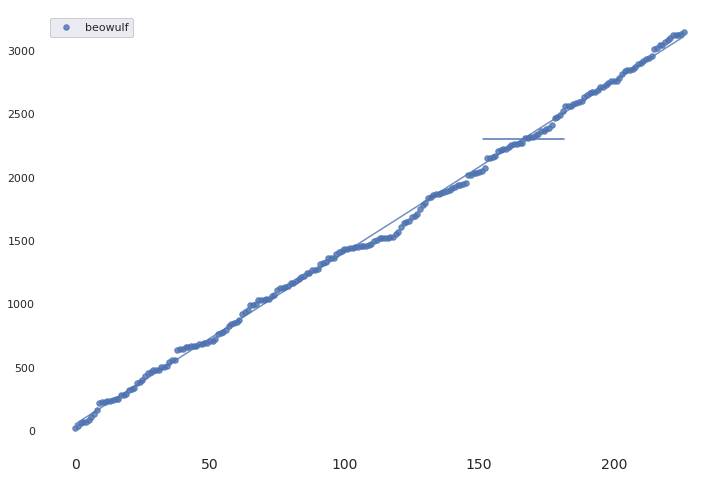

In [11]:
plot_hapax_curve(['beowulf'], hapaxes, locations, hlines={'beowulf':[2300]})

<div style="border-top: 3px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>
Let's proceed to figures in the supplement. We start with the most general one: 
Supplement. Fig. 2c giving data on (1) Christ and Satan, (2) Juliana, (3) Elene, (4) Andreas, 
(5) Beowulf, and (6) Exodus
The figure is obviously limited to display only first 60 or so compounds, we therefore pass max_=60
<ul><li>The result seems correct</ul></li>

christandsatan: slope = 55.45, r = 0.967989788334351
juliana: slope = 32.41, r = 0.9393449290246665
elene: slope = 28.29, r = 0.991973483802167
andreas: slope = 22.7, r = 0.995113753620932
beowulf: slope = 13.77, r = 0.9944709569943808
exodus: slope = 9.53, r = 0.9864721808066099


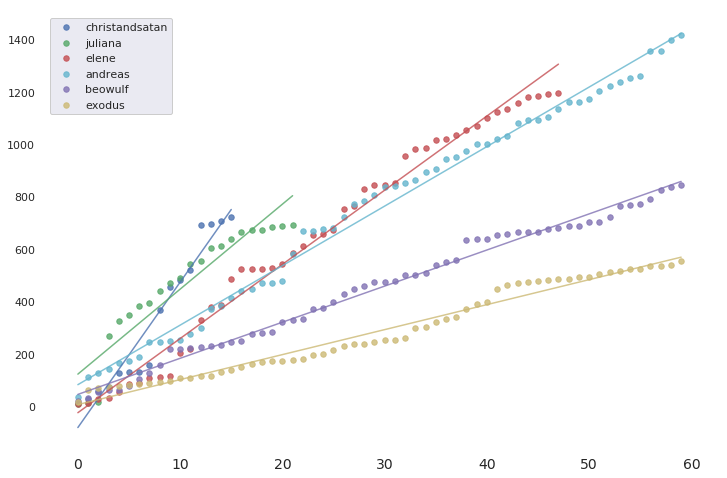

In [12]:
plot_hapax_curve(['christandsatan', 'juliana', 'elene', 'andreas', 'beowulf', 'exodus'], hapaxes, locations, max_=60)

<div style="border-top: 3px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>
Now Supplement Fig. 2A: Two samples from Genesis A and Genesis B
<ul><li>Data obviously does not correspond to how they are described in the article 
("We partitioned Genesis A into two random sections that are of comparable length to Genesis B)
but instead consists of (1) Genesis B, (2) part of Genesis A preceding B, (3) long part of A following B</ul></li>

genesisA1: slope = 23.19, r = 0.9846739453269441
genesisB: slope = 29.5, r = 0.981123933608576
genesisA2: slope = 21.12, r = 0.9920407460890228


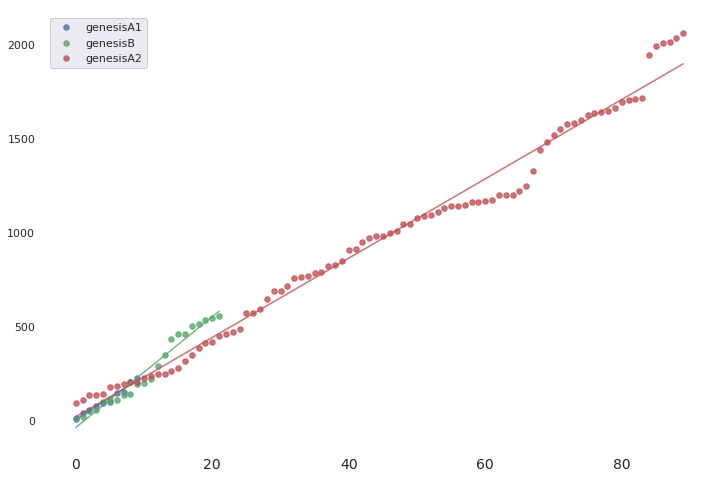

In [13]:
plot_hapax_curve(['genesisA1', 'genesisB', 'genesisA2'], hapaxes, locations)

<div style="border-top: 3px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>
Let's try to make samples for Fig. 2A on ouw own.
<p> We define two new functions: (1) to merge two texts together (in this case GenesisA1 and GenesisA2) and (2) to partition text into samples (in this case GenesisA1+2 into two samples of length corresponding to length of GenesisB

<ul><li>The result seems more or less correct (the samples may have been defined in different way originally)</ul></li>

genesisA1: slope = 20.95, r = 0.9719813440586889
genesisA2: slope = 23.15, r = 0.9932262206997875
genesisB: slope = 29.5, r = 0.981123933608576


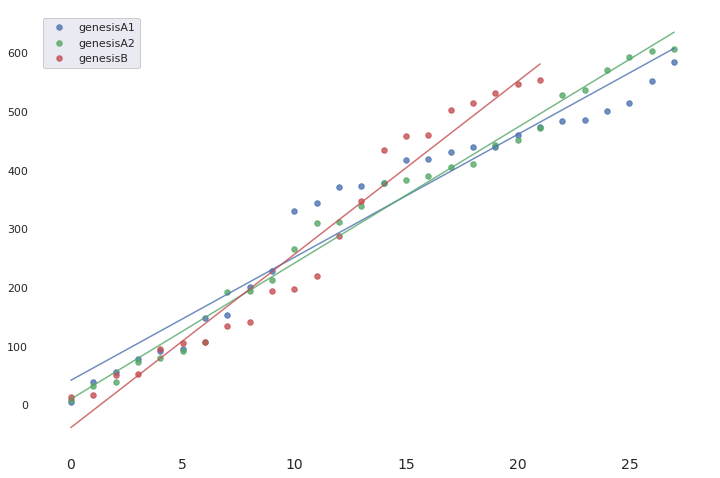

In [14]:
def merge(titles, locations, line_counts):
    '''
    titles:       [list] of titles that should be plotted | 'all' to plot all the documents
    locations:    {dict of {dicts of [lists]} giving information on where the hapaxes 
                  appear in particular texts
    line_counts:  {dict} giving the number of lines in each text
    '''
    
    locations_merged = defaultdict(lambda: defaultdict(list))
    lines_before = 0
    merged_title = ' - '.join(titles)
    
    for title in titles:
        for w in locations[title]:
            for l in locations[title][w]:
                locations_merged[merged_title][w].append(l+lines_before)
        lines_before += line_counts[title]

    return locations_merged

def samples(title, locations, sample_size, number_of_samples):
    '''
    title:              title from which samples should be taken from
    locations:          {dict of {dicts of [lists]} giving information on where the hapaxes 
                        appear in particular texts
    sample_size:        how many lines should sample contain
    number_of_samples:  how many samples to create
    '''
    
    locations_samples = defaultdict(lambda: defaultdict(list))
    
    for i in range(0, number_of_samples):
        for w in locations[title]:
            for l in locations[title][w]:
                if l > i * sample_size and l <= (i+1) * sample_size:
                    locations_samples['{0}_{1}'.format(title, i+1)][w].append(l-i*sample_size)
    
    return locations_samples

genesisA_merged = merge(['genesisA1', 'genesisA2'], locations, line_counts)
genesisA_samples = samples('genesisA1 - genesisA2', genesisA_merged, line_counts['genesisB'], 2)
genesis = {
    'genesisA1': genesisA_samples['genesisA1 - genesisA2_1'],
    'genesisA2': genesisA_samples['genesisA1 - genesisA2_2'],
    'genesisB': locations['genesisB'],
    
}
plot_hapax_curve('all', hapaxes, genesis)        

<div style="border-top: 3px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>
Finally Supplement Fig. 3b: Three random partitions of Exodus.
<p>Lets' simply try to split Exodus into 3 parts of the same length.
<ul><li>Now this is a very different result. Instead of having three similar regression lines, the slope for sample 2 is almost twice as bigger as for sample 1 and 3</ul></li>

exodus_1: slope = 6.36, r = 0.9783212657457848
exodus_2: slope = 11.38, r = 0.9753106438071025
exodus_3: slope = 6.17, r = 0.9704865495753849


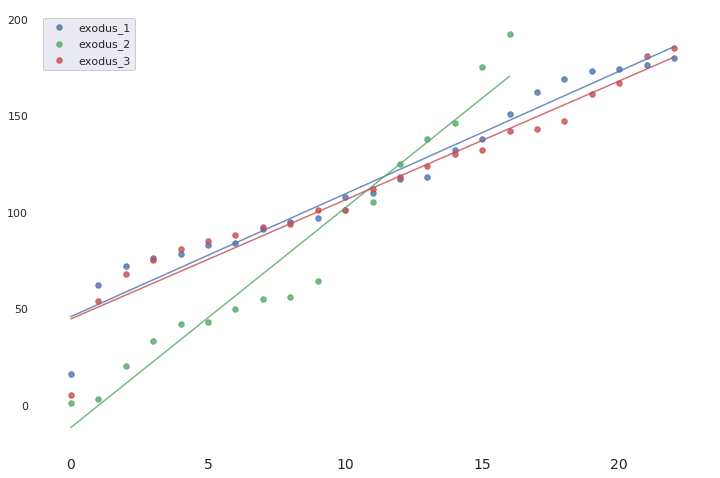

In [15]:
sample_size = math.floor(line_counts['exodus']/3)
exodus_samples = samples('exodus', locations, sample_size, 3)
plot_hapax_curve('all', hapaxes, exodus_samples)

<div style="border-top: 3px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>
Let's try partitioning into 4 samples
<ul><li>Once again there are big differences in slopes</ul></li>

exodus_1: slope = 5.89, r = 0.9420369798269473
exodus_2: slope = 7.25, r = 0.9854512048911095
exodus_3: slope = 15.48, r = 0.9896034623066985
exodus_4: slope = 5.65, r = 0.991254126884212


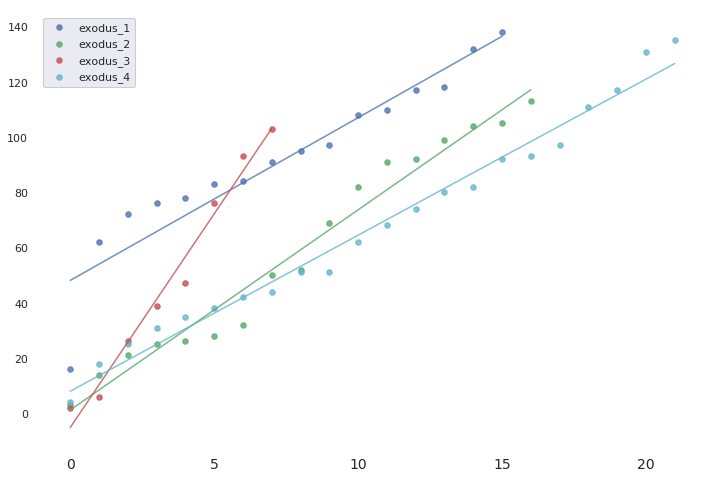

In [16]:
sample_size = math.floor(line_counts['exodus']/4)
exodus_samples = samples('exodus', locations, sample_size, 4)
plot_hapax_curve('all', hapaxes, exodus_samples)

<div style="border-top: 10px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>

<h3>Further experiments</h3>
<p>
<ul><li>Partitioning Elene into two halves gives the difference very similar to Genesis A vs. Genesis B</li></ul>


elene_1: slope = 31.25, r = 0.9792473652436587
elene_2: slope = 22.67, r = 0.979885468687283


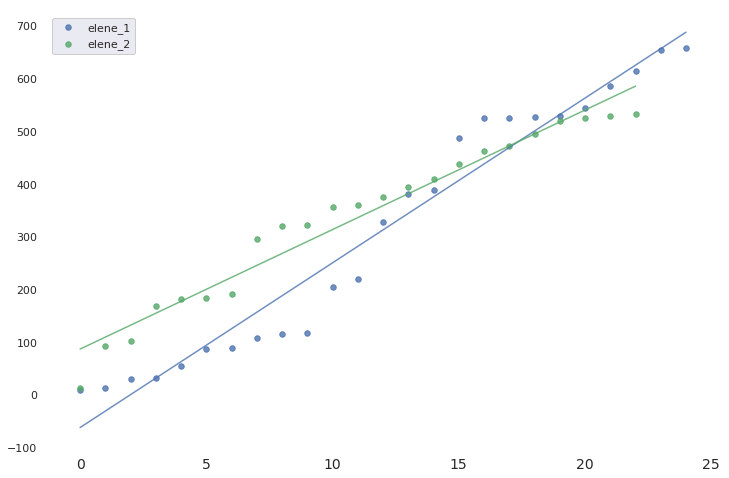

In [17]:
sample_size = math.floor(line_counts['elene']/2)
exodus_samples = samples('elene', locations, sample_size, 2)
plot_hapax_curve('all', hapaxes, exodus_samples)

<div style="border-top: 3px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>
<ul><li>Differences are striking for two halves of Juliana and Daniel, the values are far from linear fit</li></ul>


juliana_1: slope = 81.94, r = 0.9219914176349302
juliana_2: slope = 22.11, r = 0.9681816512457819


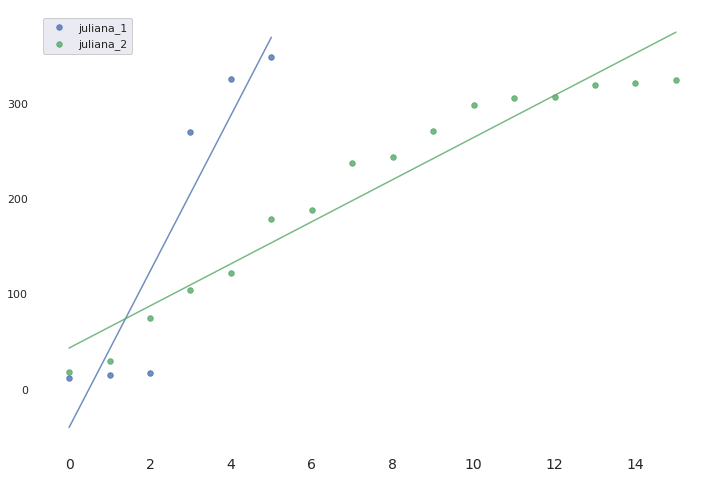

daniel_1: slope = 44.92, r = 0.9574041046241124
daniel_2: slope = 83.6, r = 0.9492476663324084


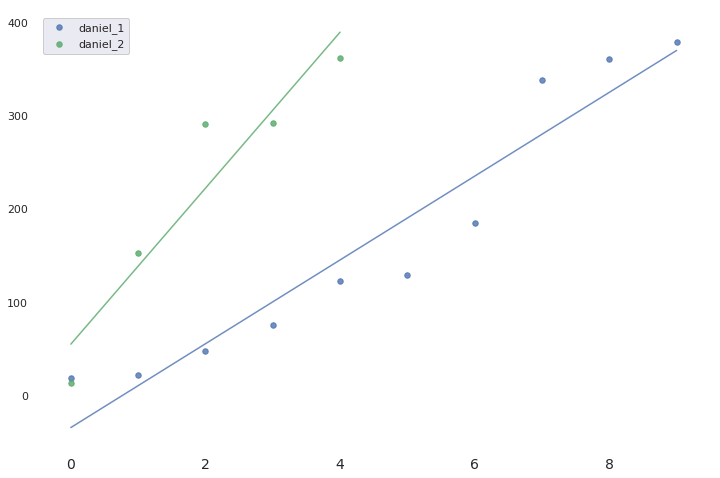

In [18]:
sample_size = math.floor(line_counts['juliana']/2)
exodus_samples = samples('juliana', locations, sample_size, 2)
plot_hapax_curve('all', hapaxes, exodus_samples)

sample_size = math.floor(line_counts['daniel']/2)
exodus_samples = samples('daniel', locations, sample_size, 2)
plot_hapax_curve('all', hapaxes, exodus_samples)

<div style="border-top: 3px solid #a6a6a6; margin-top: 30px; margin-bottom:20px"></div>
<ul><li>This is what happens when we merge some of the longest texts together: there's no evidence that they should be of the same authorship, but the quality of fit is not far from that of Beowulf. This shows how tricky this plotting method is.</li></ul>


beowulf: slope = 13.54, r = 0.9991850912311456
elene - genesisB - phoenix: slope = 28.05, r = 0.998268008334914
genesisA - andreas: slope = 23.88, r = 0.9971529083298395


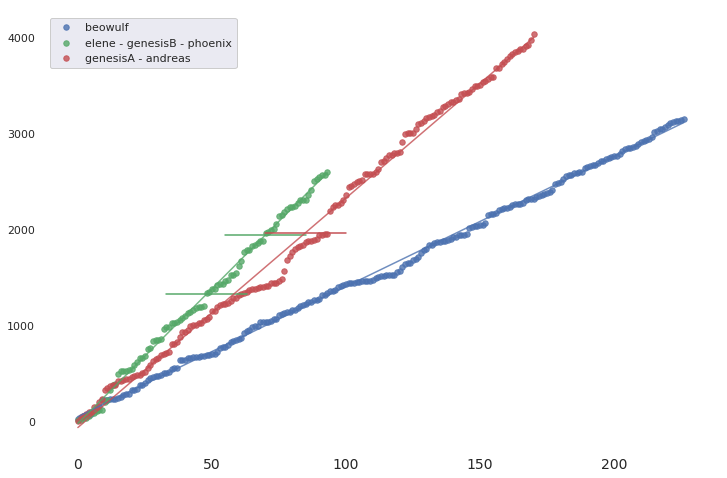

In [21]:
locations_temp = merge(['elene', 'genesisB', 'phoenix'], locations, line_counts)
locations2_temp = merge(['genesisA1', 'genesisA2', 'andreas'], locations, line_counts)

for x in locations2_temp:
    locations_temp['genesisA - andreas'] = locations2_temp[x]

hlines = {
    'elene - genesisB - phoenix': [
        line_counts['elene'], 
        line_counts['elene'] + line_counts['genesisB'], 
    ],
    'genesisA - andreas': [
        #line_counts['genesisA1'], 
        line_counts['genesisA1'] + line_counts['andreas'], 
    ],    
}

    
locations_temp['beowulf'] = locations['beowulf']
plot_hapax_curve('all', hapaxes, locations_temp, hlines=hlines)                
